In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

I0124 015634.009 _utils_internal.py:231] NCCL_DEBUG env var is set to None


I0124 015634.010 _utils_internal.py:249] NCCL_DEBUG is forced to WARN from None


I0124 015636.188 font_manager.py:1349] generated new fontManager


In [2]:
# load data

words = open("/home/yucongguo/names.txt", "r").read().splitlines()
print(words[:8])
print(f"length of words = {len(words)}")

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
length of words = 32033


In [3]:
# build the vocabulary of characters and mapping to/from integers

char = sorted(list(set(''.join(words))))
str_to_int = {string: index+1 for index, string in enumerate(char)}
str_to_int['.'] = 0
int_to_str = {index+1: string for index, string in enumerate(char)}
int_to_str[0] = '.'
print(f"str_to_int : {str_to_int}")
print(f"int_to_str : {int_to_str}")

str_to_int : {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
int_to_str : {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    #input: list of wards
    #output: X,Y

    x = []
    y = []
    for w in words:
        context = [0] * block_size #assume all word start with "..."
        for character in w+'.':
            next_char_index = str_to_int[character]
            x.append(context)
            y.append(next_char_index)
            context = context[1:] + [next_char_index]

    x = torch.tensor(x)
    y = torch.tensor(y)

    return x, y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

x_train,y_train = build_dataset(words[:n1])
x_val,y_val = build_dataset(words[n1:n2])
x_test,y_test = build_dataset(words[n2:])

print(f"x_train shape : {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape : {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape : {x_test.shape}, y_test shape: {y_test.shape}")


x_train shape : torch.Size([182625, 3]), y_train shape: torch.Size([182625])
x_val shape : torch.Size([22655, 3]), y_val shape: torch.Size([22655])
x_test shape : torch.Size([22866, 3]), y_test shape: torch.Size([22866])


## previous MLP model

In [5]:
# MLP model

#define parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocal_size = len(str_to_int)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocal_size,n_embd), generator = g)  # define embed matrix
w1 = torch.randn((n_embd * block_size , n_hidden), generator  = g) 
b1 = torch.randn(n_hidden, generator = g)
w2 = torch.randn((n_hidden, vocal_size), generator = g)
b2 = torch.randn(vocal_size, generator = g)
parameters = [C, w1,b1,w2,b2]

for p in parameters:
    p.requires_grad = True

print(f'total number of parameters: {sum(p.nelement() for p in parameters)}\n')

#define MLP model

max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    mini_batch = torch.randint(0, x_train.shape[0], (batch_size, ), generator = g) # each minibatch has 332 data
    x_train_b = x_train[mini_batch]
    y_train_b = y_train[mini_batch]

    emb_layer = C[x_train_b] #(32,3,10)
    hidden_layer = torch.tanh(emb_layer.view(emb_layer.shape[0],-1) @ w1 + b1)  #(32,200)
    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y_train_b) 

    for p in parameters:
        p.grad = None
    loss.backward()


    learn_rate = 0.1 if i> 100000 else 0.01
    for p in parameters:
        p.data += -learn_rate * p.grad

    if i%10000 ==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())





total number of parameters: 11897



      0/ 200000: 27.8817


  10000/ 200000: 4.0974


  20000/ 200000: 2.9530


  30000/ 200000: 2.9583


  40000/ 200000: 2.3027


  50000/ 200000: 2.7252


  60000/ 200000: 2.4195


  70000/ 200000: 2.1045


  80000/ 200000: 2.2040


  90000/ 200000: 2.4836


 100000/ 200000: 2.0478


 110000/ 200000: 2.7586


 120000/ 200000: 1.9789


 130000/ 200000: 2.6731


 140000/ 200000: 2.3900


 150000/ 200000: 2.3202


 160000/ 200000: 2.1965


 170000/ 200000: 1.7711


 180000/ 200000: 2.2012


 190000/ 200000: 1.9146


In [6]:
# calculate the training loss and validation loss

@torch.no_grad() #decorator disables gradient tracking , to save memory consumption
def get_loss(split):
    x,y = {
        "train":(x_train,y_train),
        "val":(x_val,y_val),
        "test":(x_test,y_test)
    }[split]

    emb_layer = C[x] #(32,3,10)
    hidden_layer = torch.tanh(emb_layer.view(emb_layer.shape[0],-1) @ w1 + b1)  #(32,200)
    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y) 
    print(split, loss.item())

get_loss("train")
get_loss("val")

train 2.2353692054748535
val 2.276008129119873


In [7]:
# sample from the model
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(int_to_str[i] for i in out))

carmahzadelle.
khy.
myli.
eviyah.
casen.
jazhuel.
den.
archireei.
nekoniahceriiv.
kane.
gyu.
amondin.
quint.
shon.
emira.
bryoque.
ogiearyxi.
jayek.
drudy.
eddeco.


## fixing the initial loss

In [8]:
print("note that the initial loss for the MLP model is 27 which is too high.\n" )

print("expected probablity of next character to be true are 1/27, therefore the loss would be the following:")
expected_loss = -torch.tensor(1/27).log()
print(f"expected_loss = {expected_loss}\n")

print("the reason is that the since the intialization of w1, b1, w2, b2 are too high, the logit will be high, therefore, the initial loss is high")
print("example:")
logits = torch.tensor([0,0,5,0]).float()
probs = torch.softmax(logits, dim = 0)
loss1 = -probs[2].log()
print(f"loss1 = {loss1.item()}")
logits = torch.tensor([0,10,0,0]).float()
probs = torch.softmax(logits, dim = 0)
loss2 = -probs[2].log()
print(f"loss2 = {loss2.item()}")

note that the initial loss for the MLP model is 27 which is too high.

expected probablity of next character to be true are 1/27, therefore the loss would be the following:
expected_loss = 3.295836925506592

the reason is that the since the intialization of w1, b1, w2, b2 are too high, the logit will be high, therefore, the initial loss is high
example:
loss1 = 0.020012274384498596
loss2 = 10.000136375427246


In [9]:
# to fix the inital, redefine the initialization of w2, b2

# MLP model

#define parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocal_size = len(str_to_int)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocal_size,n_embd), generator = g)  # define embed matrix
w1 = torch.randn((n_embd * block_size , n_hidden), generator  = g) 
b1 = torch.randn(n_hidden, generator = g)
w2 = torch.randn((n_hidden, vocal_size), generator = g) * 0.1
b2 = torch.randn(vocal_size, generator = g) * 0
parameters = [C, w1,b1,w2,b2]

for p in parameters:
    p.requires_grad = True


#define MLP model

max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    mini_batch = torch.randint(0, x_train.shape[0], (batch_size, ), generator = g) # each minibatch has 332 data
    x_train_b = x_train[mini_batch]
    y_train_b = y_train[mini_batch]

    emb_layer = C[x_train_b] #(32,3,10)
    hidden_layer = torch.tanh(emb_layer.view(emb_layer.shape[0],-1) @ w1 + b1)  #(32,200)
    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y_train_b) 

    for p in parameters:
        p.grad = None
    loss.backward()


    learn_rate = 0.1 if i> 100000 else 0.01
    for p in parameters:
        p.data += -learn_rate * p.grad

    if i%10000 ==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    break

print("\nnote that the logit of the first data is smaller")
print(logit[0])

      0/ 200000: 4.2326

note that the logit of the first data is smaller
tensor([-0.2490,  3.5232, -1.2675,  0.5407,  1.6622, -1.1708, -0.1398,  0.1242,
         0.9210,  1.1347,  1.3624, -0.9252,  0.4438, -2.4594, -0.9714,  0.1247,
        -0.9572, -1.3763, -2.3287, -0.1374,  2.4522,  1.6165,  1.6649, -1.0944,
        -2.1544,  0.7255,  1.1413], grad_fn=<SelectBackward0>)


## fixting the saturate tanh

it is a issue because when back pass, the gradient of point clost to 1 or -1 is 0.

which means w1, b1 gradient will be 0 and w1, b1 will not be updated


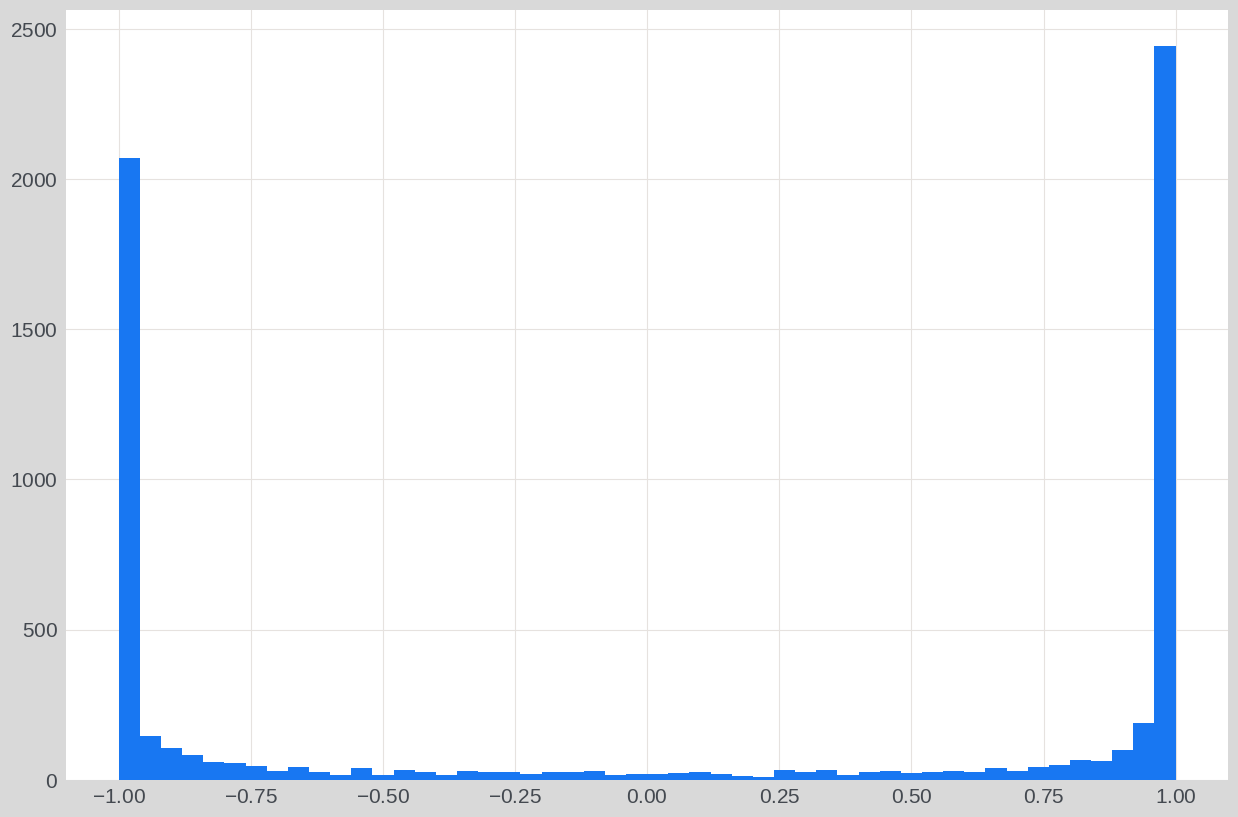

In [10]:
# take a look at the output of hidden layer 
plt.hist(hidden_layer.view(-1).tolist(),50)
print("it is a issue because when back pass, the gradient of point clost to 1 or -1 is 0.\n")
print("which means w1, b1 gradient will be 0 and w1, b1 will not be updated")

if a column below is all white, which means that neuron is dead for all of the data.


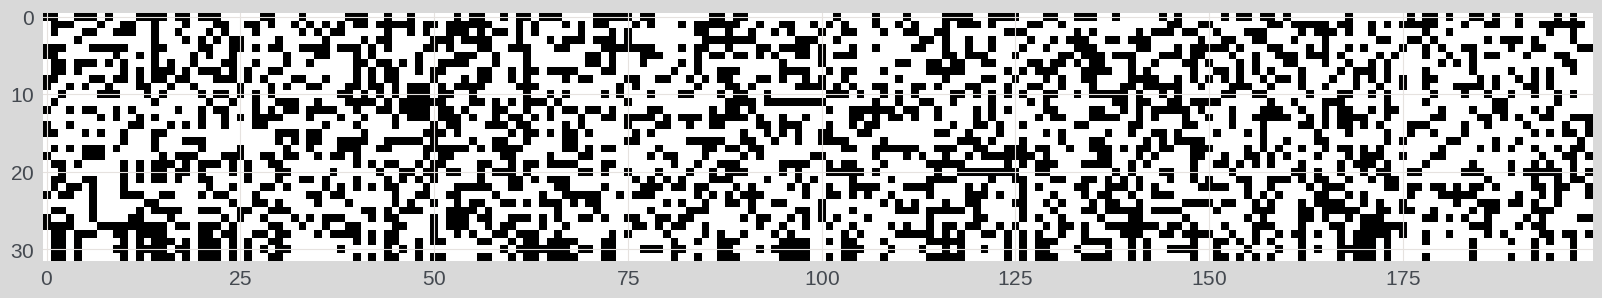

In [11]:
plt.figure(figsize = (20,10))
plt.imshow(hidden_layer.abs()>0.99, cmap = "gray", interpolation= "nearest")
print("if a column below is all white, which means that neuron is dead for all of the data.")

In [12]:
# to fix the satuate hidden layer, redefine the initialization of w1, b1

# MLP model

#define parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocal_size = len(str_to_int)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocal_size,n_embd), generator = g)  # define embed matrix
w1 = torch.randn((n_embd * block_size , n_hidden), generator  = g) *0.1
b1 = torch.randn(n_hidden, generator = g) * 0.01 # add some bias
w2 = torch.randn((n_hidden, vocal_size), generator = g) * 0.1
b2 = torch.randn(vocal_size, generator = g) * 0
parameters = [C, w1,b1,w2,b2]

for p in parameters:
    p.requires_grad = True


#define MLP model

max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    mini_batch = torch.randint(0, x_train.shape[0], (batch_size, ), generator = g) # each minibatch has 332 data
    x_train_b = x_train[mini_batch]
    y_train_b = y_train[mini_batch]

    emb_layer = C[x_train_b] #(32,3,10)
    hidden_layer = torch.tanh(emb_layer.view(emb_layer.shape[0],-1) @ w1 + b1)  #(32,200)
    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y_train_b) 

    for p in parameters:
        p.grad = None
    loss.backward()


    learn_rate = 0.1 if i> 100000 else 0.01
    for p in parameters:
        p.data += -learn_rate * p.grad

    if i%10000 ==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    break

print("\nnote that the logit of the first data is smaller")
print(logit[0])

      0/ 200000: 3.5464

note that the logit of the first data is smaller
tensor([-0.4052,  1.4206, -0.2834,  0.1989,  0.5470, -0.1210, -0.1711,  0.0485,
         0.0161,  0.3825,  1.0106, -0.3896,  0.0496, -1.1520, -0.3516,  0.1675,
        -0.0654, -0.9205, -1.3525, -0.0628,  0.8002,  0.8804,  0.6854, -0.6522,
        -0.8921,  0.7273,  0.6559], grad_fn=<SelectBackward0>)


new histogram of hidden layer value distribution.

data are between -1 to 1 which is good


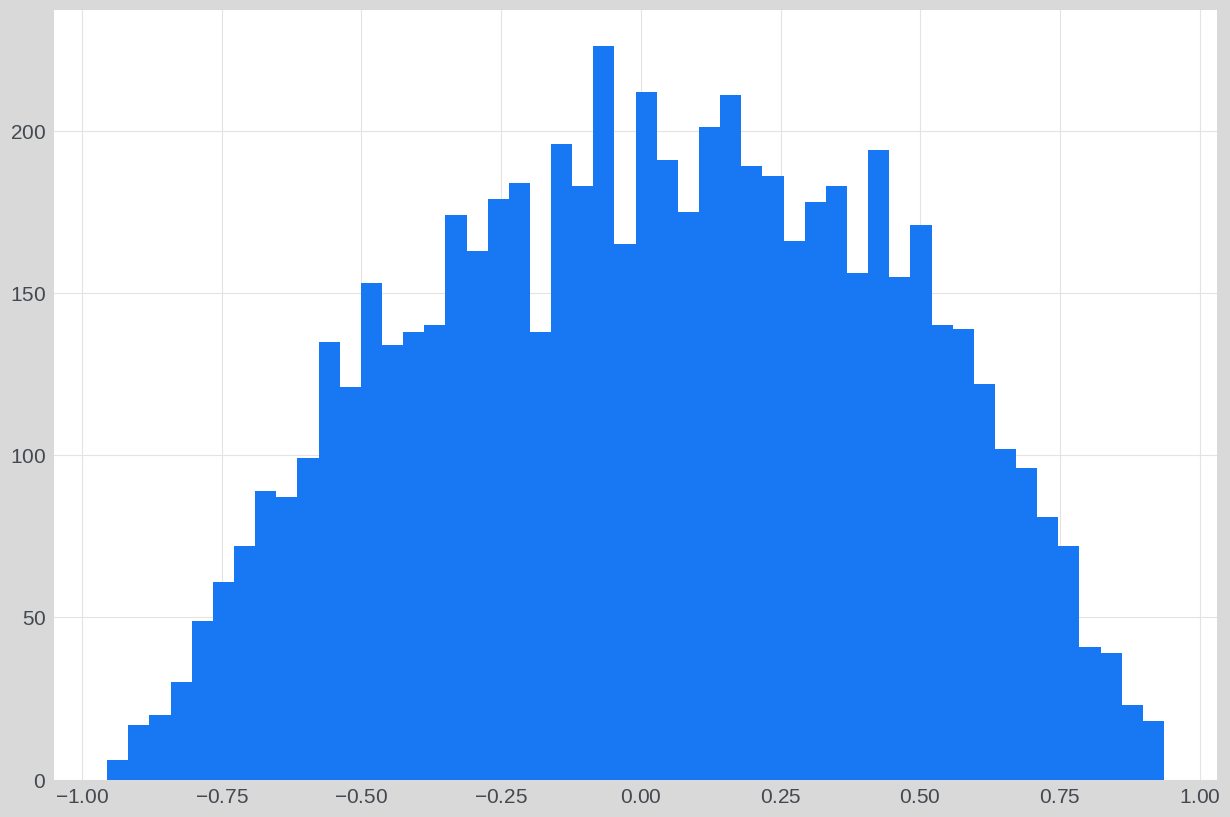

In [13]:
# take a look at new the output of hidden layer 
plt.hist(hidden_layer.view(-1).tolist(),50)
print("new histogram of hidden layer value distribution.\n")
print("data are between -1 to 1 which is good")

for new hidden layer output, it is all activated


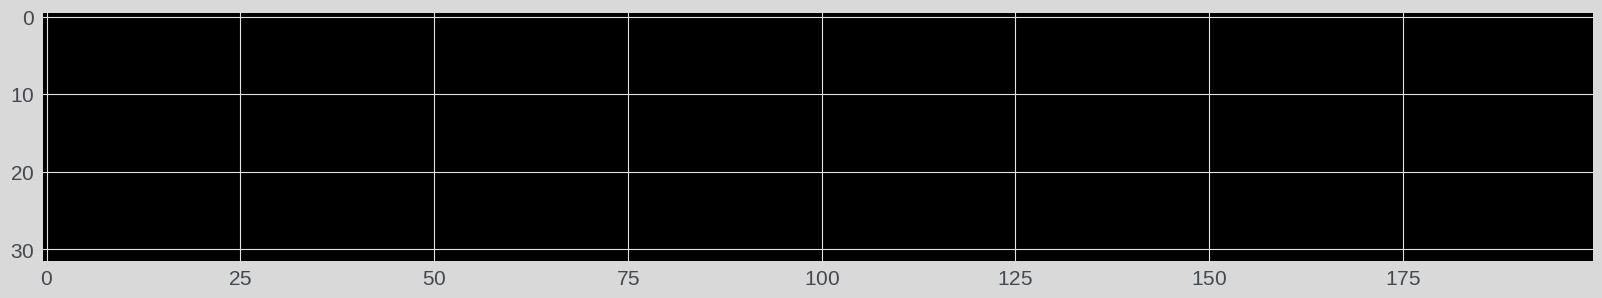

In [14]:
plt.figure(figsize = (20,10))
plt.imshow(hidden_layer.abs()>0.99, cmap = "gray", interpolation= "nearest")
print("for new hidden layer output, it is all activated")

## calculating the initial scale: Kaiming initialization

In [16]:
print("in forward pass, gausian initialization will cause the data more spread out in next layer, when go into nonlinear layer, nonlinear layer might be deactivated in backward pass")

x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x@w 
print(f"\nbefore forward pass, mean= {x.mean()}, std = {x.std()}")
print(f"after forward pass, mean= {y.mean()}, std = {y.std()}")

print("\nto fix it, we can assign smaller inital w ")
x = torch.randn(1000,10)
w = torch.randn(10,200) *0.4
y = x@w 
print(f"before forward pass, mean= {x.mean()}, std = {x.std()}")
print(f"after forward pass, mean= {y.mean()}, std = {y.std()}")

print("\nGoal: find the good initialization w so that after the forward pass, std are also 1")

in forward pass, gausian initialization will cause the data more spread out in next layer, when go into nonlinear layer, nonlinear layer might be deactivated in backward pass

before forward pass, mean= -0.0028258992824703455, std = 1.0069223642349243
after forward pass, mean= 0.00026580062694847584, std = 3.1816365718841553

to fix it, we can assign smaller inital w 
before forward pass, mean= -0.007137144450098276, std = 0.9871163964271545
after forward pass, mean= 0.002338755875825882, std = 1.2360187768936157

Goal: find the good initialization w so that after the forward pass, std are also 1


In [17]:
print("generalized initialization solution: w / sqrt(fan_in)")
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10 **0.5
y = x@w 
print(f"\nbefore forward pass, mean= {x.mean()}, std = {x.std()}")
print(f"after forward pass, mean= {y.mean()}, std = {y.std()}")

generalized initialization solution: w / sqrt(fan_in)

before forward pass, mean= 0.007452878635376692, std = 1.0131685733795166
after forward pass, mean= -0.00020434097677934915, std = 0.9916239380836487


In [18]:
print("kaiming initialization: w / (gain/sqrt(fan_in)), b=0")
x = torch.randn(1000,10)
w = torch.randn(10,200) / (5/3)/ 10 **0.5
y = x@w 
print(f"\nbefore forward pass, mean= {x.mean()}, std = {x.std()}")
print(f"after forward pass, mean= {y.mean()}, std = {y.std()}")

kaiming initialization: w / (gain/sqrt(fan_in)), b=0

before forward pass, mean= -0.0072313034906983376, std = 1.0087683200836182
after forward pass, mean= -0.000664476421661675, std = 0.5963590741157532


In [19]:
# use kaiming initialaztion in MLP model

# MLP model

#define parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocal_size = len(str_to_int)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocal_size,n_embd), generator = g)  # define embed matrix
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #kaiming initialazation
b1 = torch.randn(n_hidden, generator = g) * 0.01 # add some bias
w2 = torch.randn((n_hidden, vocal_size), generator = g) * 0.1
b2 = torch.randn(vocal_size, generator = g) * 0
parameters = [C, w1,b1,w2,b2]

for p in parameters:
    p.requires_grad = True


#define MLP model

max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    mini_batch = torch.randint(0, x_train.shape[0], (batch_size, ), generator = g) # each minibatch has 332 data
    x_train_b = x_train[mini_batch]
    y_train_b = y_train[mini_batch]

    emb_layer = C[x_train_b] #(32,3,10)
    hidden_layer = torch.tanh(emb_layer.view(emb_layer.shape[0],-1) @ w1 + b1)  #(32,200)
    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y_train_b) 

    for p in parameters:
        p.grad = None
    loss.backward()


    learn_rate = 0.1 if i> 100000 else 0.01
    for p in parameters:
        p.data += -learn_rate * p.grad

    if i%10000 ==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    break

print("\nhidden layer std:")
print(hidden_layer.std())

      0/ 200000: 3.9518

hidden layer std:
tensor(0.7376, grad_fn=<StdBackward0>)


## Batch normalization

standardize each batch in hidden layer to be gaussian distributed, \
this is used to reduce the covariate shift between each minibatch.\
also by normalizing layer allow us to use higher learning rate and be less carful about initialiazation

In [21]:
# batch normalization algorithm

'''
Input: Values of x over a mini-batch: B = {x1...m};
Parameters to be learned: γ, β 
Output: {yi = BNγ,β(xi)} 
µB ←1/m sum(xi).                    mini-batch mean\
σB^2 ← 1/m sum((xi − µB)^2).        mini-batch variance
xbi ← (xi − µB) / sqrt(B^2 + ǫ).    normalize
yi ← γxbi + β ≡ BNγ,β(xi)           scale and shift
'''

'''
also when in prediction, need to normalized the data as well.
There fore we need a mean and variance over the entire training set
'''

'''
since we introdice a normalization bias, we can get rid of b1
'''

'''
normally use batch normalization layer after linear layer (multiplication)  and convolution layer
'''

'\nnormally use batch normalization layer after linear layer (multiplication)  and convolution layer\n'

In [22]:
# batch normalization in hidden layer

# MLP model

#define parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
vocal_size = len(str_to_int)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocal_size,n_embd), generator = g)  # define embed matrix
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #kaiming initialazation
#b1 = torch.randn(n_hidden, generator = g) * 0.01 # add some bias
w2 = torch.randn((n_hidden, vocal_size), generator = g) * 0.1
b2 = torch.randn(vocal_size, generator = g) * 0


# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, w1,w2,b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True


#define MLP model

max_steps = 200000
batch_size = 32
loss_i = []

for i in range(max_steps):
    mini_batch = torch.randint(0, x_train.shape[0], (batch_size, ), generator = g) # each minibatch has 332 data
    x_train_b = x_train[mini_batch]
    y_train_b = y_train[mini_batch]

    #forward pass
    emb_layer = C[x_train_b] #(32,3,10)
    #linear layer
    hidden_layer_pre =  emb_layer.view(emb_layer.shape[0],-1) @ w1
    #batchnorm layer
    bnmeani = hidden_layer_pre.mean(0, keepdim=True)
    bnstdi = hidden_layer_pre.std(0, keepdim=True)
    hidden_layer_pre_normalized = bngain * (hidden_layer_pre - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # non_linearity layer
    hidden_layer = torch.tanh(hidden_layer_pre_normalized)  #(32,200)

    logit = hidden_layer @ w2 + b2  #(32,27)
    loss = F.cross_entropy(logit, y_train_b) 

    for p in parameters:
        p.grad = None
    loss.backward()


    learn_rate = 0.1 if i> 100000 else 0.01
    for p in parameters:
        p.data += -learn_rate * p.grad

    if i%10000 ==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    break



      0/ 200000: 3.9406


## implement DNN module

In [25]:
#define DNN module

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        if self.training: # use in training
            x_mean = x.mean(0, keepdim = True) # batch mean
            x_var = x.var(0, keepdim = True) # batch variance
        else: # use in testing
            x_mean = self.running_mean
            x_var = self.running_var 
        
        x_normalized = (x-x_mean) / torch.sqrt(x_var + self.eps) # normalize x
        self.out = self.gamma * x_normalized + self.beta #scale and shift. need to learn gamma and beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


### model 1 without tanh layer

In [46]:
# MLP model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(str_to_int)

C = torch.randn((vocab_size, n_embd),   generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), 
    Linear(           n_hidden, n_hidden, bias=False),  
    Linear(           n_hidden, n_hidden, bias=False),  
    Linear(           n_hidden, n_hidden, bias=False),  
    Linear(           n_hidden, n_hidden, bias=False),  
    Linear(           n_hidden, vocab_size, bias=False), 
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True



# training model

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    x_train_batch, y_train_batch = x_train[ix], y_train[ix] # batch X,Y

    # forward pass
    emb = C[x_train_batch] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y_train_batch) # loss function
    print(loss)
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #with torch.no_grad():
        #ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    
    break # AFTER_DEBUG: would take out obviously to run full optimization

45970
tensor(4.0240, grad_fn=<NllLossBackward0>)
      0/ 200000: 4.0240


layer 0 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 1 (    Linear): mean -0.00, std 0.00, saturated: 0.00%
layer 2 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (    Linear): mean +0.00, std 0.00, saturated: 0.00%
layer 4 (    Linear): mean -0.00, std 0.00, saturated: 0.00%

note that without tanh layer, the gradient of deep neural network is 0 at the last layer



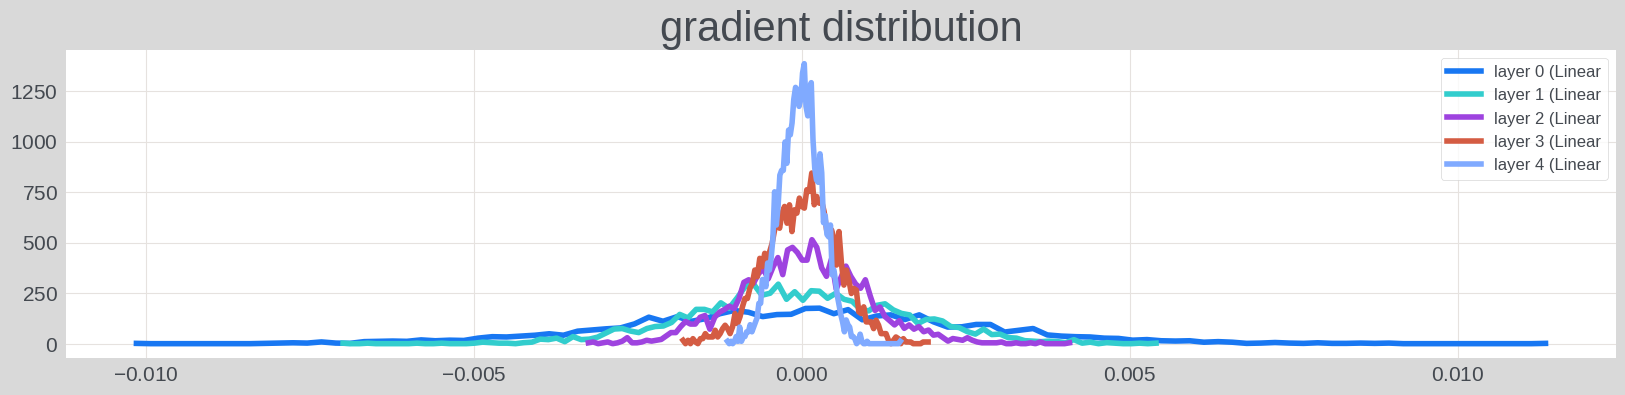

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Linear):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

print("\nnote that without tanh layer, the gradient of deep neural network is 0 at the last layer\n")


### model 2 without normalization layer

In [58]:
# MLP model

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
vocab_size = len(str_to_int)

C = torch.randn((vocab_size, n_embd),   generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False),  Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  Tanh(),
    Linear(           n_hidden, n_hidden, bias=False),  Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), 
]


with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True



# training model

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []


for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
    x_train_batch, y_train_batch = x_train[ix], y_train[ix] # batch X,Y

    # forward pass
    emb = C[x_train_batch] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y_train_batch) # loss function
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i>1000:

        break # AFTER_DEBUG: would take out obviously to run full optimization

45970
      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.34%
layer 3 (      Tanh): mean +0.01, std 0.73, saturated: 12.34%
layer 5 (      Tanh): mean +0.00, std 0.75, saturated: 14.88%
layer 7 (      Tanh): mean -0.05, std 0.74, saturated: 13.22%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 12.16%

note that without normalization layer, if we multiple linear layer weight with 5/3 , the std after tanh layer are similar

if we are not multiple the linear layer, the std after tanh will decrease


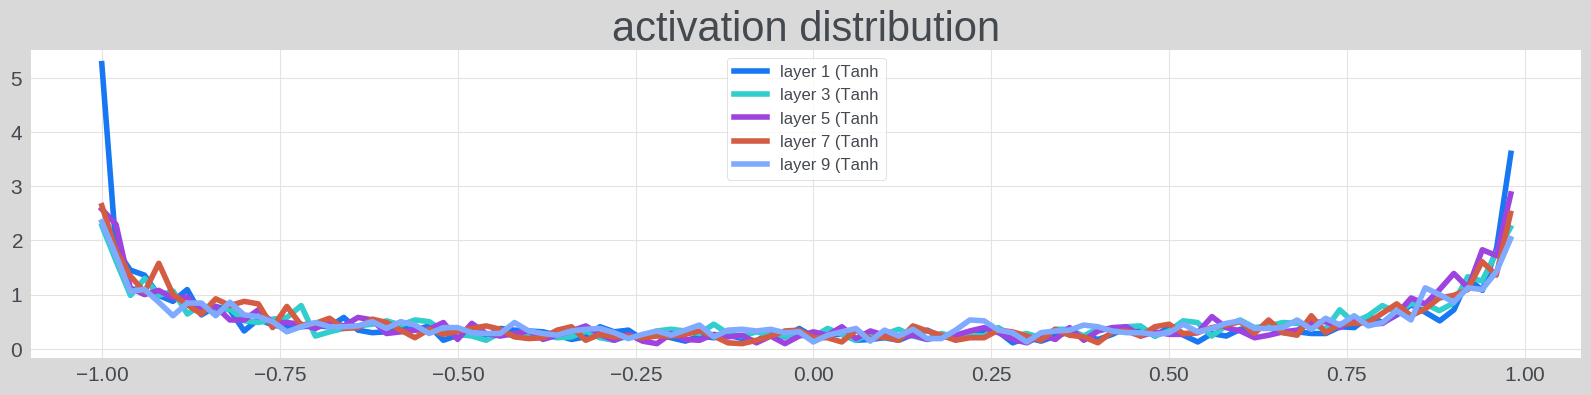

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

print("\nnote that without normalization layer, if we multiple linear layer weight with 5/3 , the std after tanh layer are similar\n")
print("if we are not multiple the linear layer, the std after tanh will decrease")

weight   (27, 10) | mean +0.000837 | std 1.002593e-02 | grad:data ratio 1.002346e-02
weight  (30, 100) | mean -0.000012 | std 8.433931e-03 | grad:data ratio 2.695509e-02
weight (100, 100) | mean -0.000007 | std 7.231345e-03 | grad:data ratio 4.298102e-02
weight (100, 100) | mean +0.000066 | std 6.237129e-03 | grad:data ratio 3.675423e-02
weight (100, 100) | mean +0.000009 | std 6.353625e-03 | grad:data ratio 3.761948e-02
weight (100, 100) | mean +0.000094 | std 5.404347e-03 | grad:data ratio 3.208923e-02
weight  (100, 27) | mean -0.000000 | std 2.309206e-02 | grad:data ratio 3.210137e-01

plot grad to data ratio plot to see how much will data get updated

noted that the last layer grad weight is more close to 0 and grad to data ratio is smaller because we manually multiple the last layer weight to 0.1


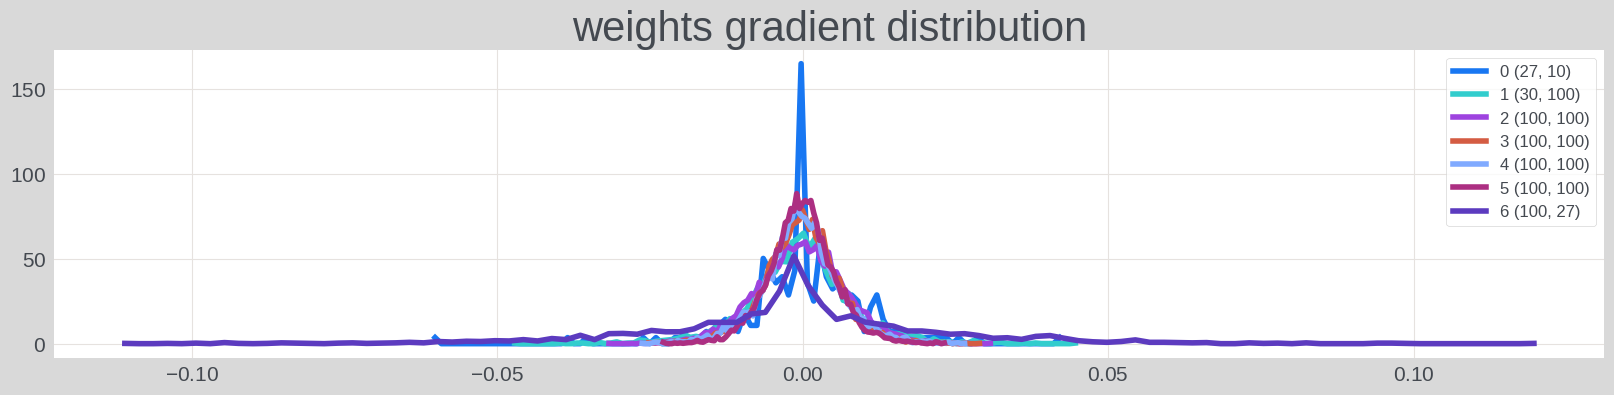

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

print("\nplot grad to data ratio plot to see how much will data get updated")
print("\nnoted that the last layer grad weight is more close to 0 and grad to data ratio is smaller because we manually multiple the last layer weight to 0.1")

lr*grad to weight ratio

the ratio increases in the beginning of the iteration and stablize during the training

the larget the value which means the weight is going through a lot of change

ideally the value should be around 1e-3

if value is below 1e-3, which means the weight is training not fast enough, need to increase the learning rate

noted that the last layer is different because we manually multiple the last layer weight to 0.1


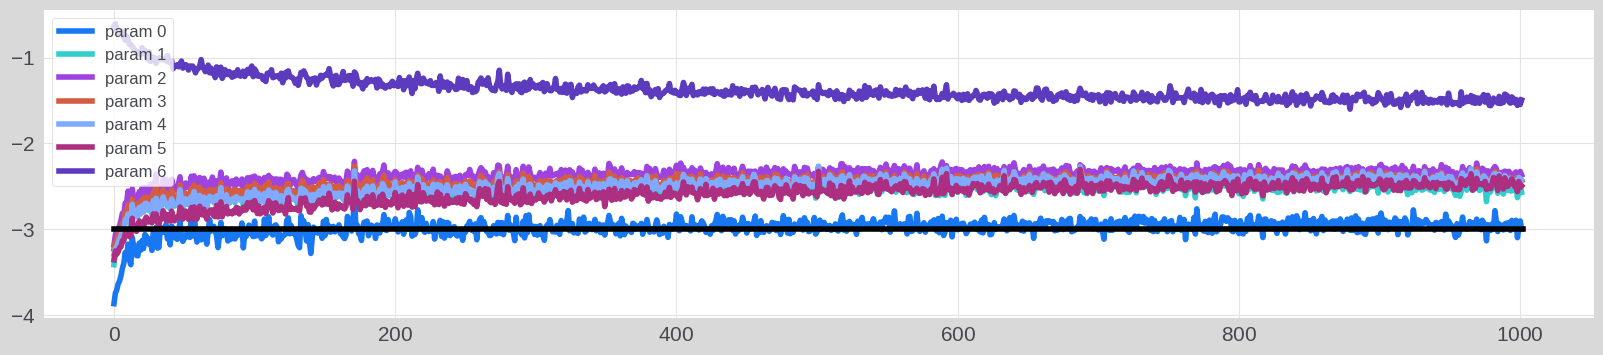

In [65]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

print("lr*grad to weight ratio")
print("\nthe ratio increases in the beginning of the iteration and stablize during the training")
print("\nthe larget the value which means the weight is going through a lot of change")
print("\nideally the value should be around 1e-3")
print("\nif value is below 1e-3, which means the weight is training not fast enough, need to increase the learning rate")
print("\nnoted that the last layer is different because we manually multiple the last layer weight to 0.1")

### model

In [71]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 50000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, x_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = x_train[ix], y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#   if i >= 1000:
#     break # AFTER_DEBUG: would take out obviously to run full optimization

47024
      0/  50000: 3.2870


  10000/  50000: 2.3273


  20000/  50000: 2.1019


  30000/  50000: 1.9020


  40000/  50000: 2.1643


layer 2 (      Tanh): mean +0.00, std 0.68, saturated: 10.66%
layer 5 (      Tanh): mean -0.02, std 0.71, saturated: 12.84%
layer 8 (      Tanh): mean +0.00, std 0.73, saturated: 12.16%
layer 11 (      Tanh): mean +0.01, std 0.74, saturated: 10.97%
layer 14 (      Tanh): mean +0.02, std 0.74, saturated: 10.41%


Text(0.5, 1.0, 'activation distribution')

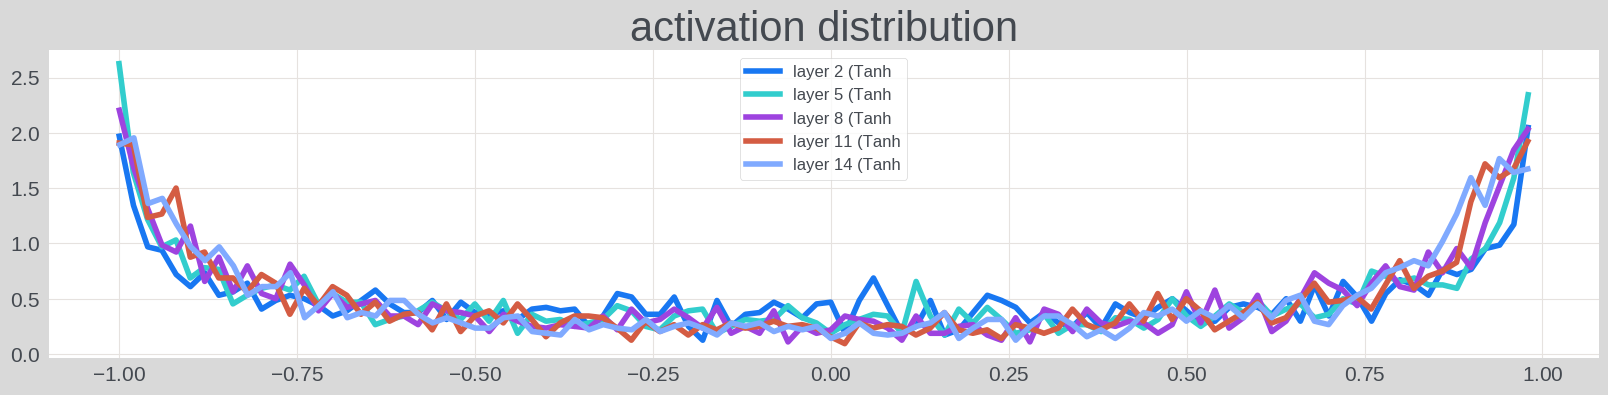

In [72]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.487726e-03
layer 5 (      Tanh): mean +0.000000, std 2.493955e-03
layer 8 (      Tanh): mean +0.000000, std 2.623432e-03
layer 11 (      Tanh): mean -0.000000, std 2.478066e-03
layer 14 (      Tanh): mean -0.000000, std 2.708361e-03


Text(0.5, 1.0, 'gradient distribution')

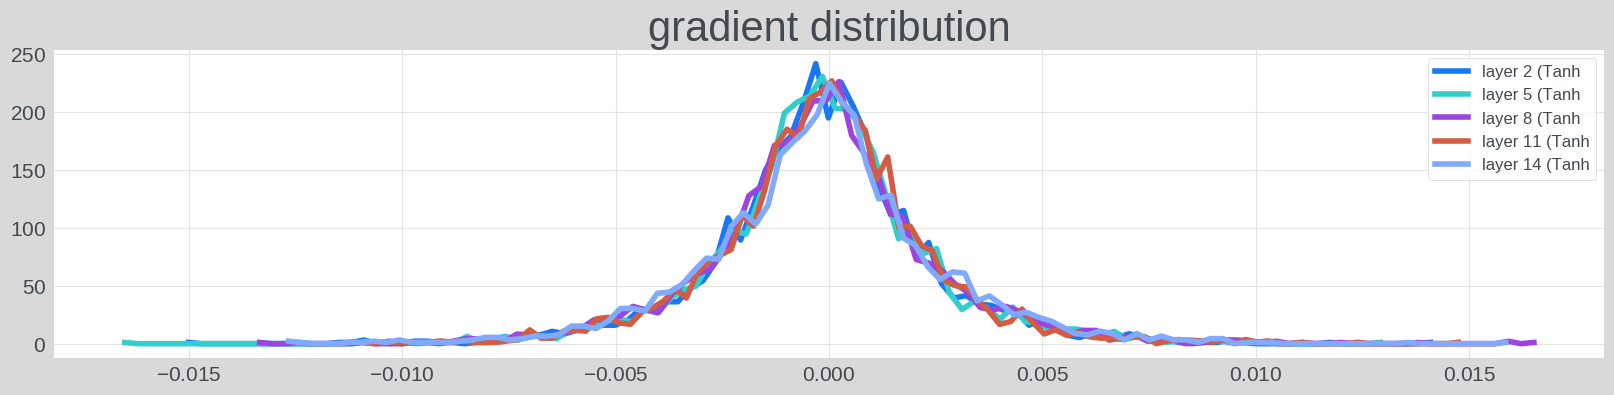

In [73]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 1.066784e-02 | grad:data ratio 1.030598e-02
weight  (30, 100) | mean -0.000342 | std 7.040999e-03 | grad:data ratio 2.448921e-02
weight (100, 100) | mean -0.000059 | std 4.671611e-03 | grad:data ratio 2.720656e-02
weight (100, 100) | mean +0.000050 | std 4.824315e-03 | grad:data ratio 2.870049e-02
weight (100, 100) | mean -0.000054 | std 4.931382e-03 | grad:data ratio 3.040354e-02
weight (100, 100) | mean -0.000053 | std 4.407526e-03 | grad:data ratio 2.852729e-02
weight  (100, 27) | mean -0.000001 | std 7.871136e-03 | grad:data ratio 3.264526e-02


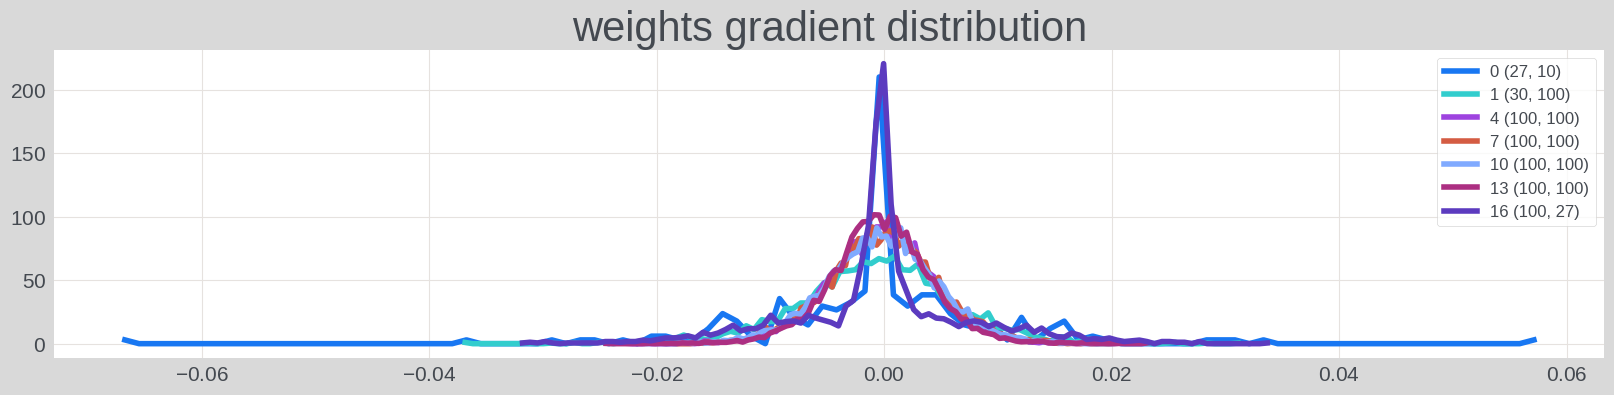

In [74]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

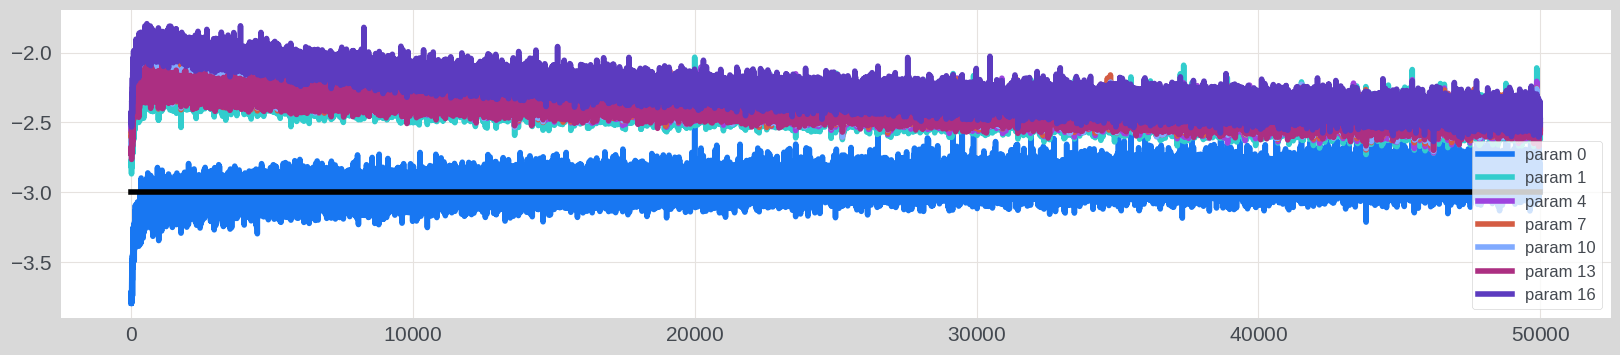

In [75]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [76]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (x_train, y_train),
    'val': (x_val, y_val),
    'test': (x_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.09787917137146
val 2.1328377723693848


In [78]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(int_to_str[i] for i in out)) # decode and print the generated word

carmah.
amillissa.
jari.
reety.
halayan.
jazhutn.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
join.
quint.
shon.
raiviani.
wate.
madiarynix.
kael.
dura.
